<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/Organizing_memories_for_generalization_in_complementary_learning_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
import matplotlib.pyplot as plt


class TSN():

    def __init__(self, input_dim, output_dim, P, P_test, SNR, lr = 0.05, rand_seed = 101):
        self.N = input_dim
        self.output_dim = output_dim
        self.P = P
        self.P_test = P_test
        self.variance_w = snr_to_var(SNR)[0]
        self.variance_e = snr_to_var(SNR)[1]
        self.lr = lr
        torch.manual_seed(rand_seed)
        noise_train = torch.normal(0, self.variance_e**0.5, size = [self.P,1])
        noise_test = torch.normal(0, self.variance_e**0.5, size = [self.P_test,1])
        W_t = torch.normal(0, self.variance_w**0.5, size=(self.N, 1))
        self.train_x = torch.normal(0, (1/self.N)**0.5, size=(self.P, self.N))
        self.train_y = torch.matmul(self.train_x, W_t) + noise_train
        self.test_x = torch.normal(0, (1/self.N)**0.5, size=(self.P_test, self.N))
        self.test_y = torch.matmul(self.test_x, W_t) + noise_test

    def training_loop(self, nepoch = 1000, reg_strength = 0):

        model = nn.Sequential(nn.Linear(self.N,self.output_dim,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=self.lr*(self.N/2), weight_decay = reg_strength) # to match the learnrate in the matlab implementation.
        optimizer.zero_grad()

        with torch.no_grad():
             list(model.parameters())[0].zero_()

        Et = np.zeros((nepoch,1))
        Eg = np.zeros((nepoch,1))
        print_iter = 200

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(self.train_y, model(self.train_x))
            train_error.backward()
            optimizer.step()
            Et[i] = train_error.detach().numpy()
            with torch.no_grad():
                 test_error = criterion(self.test_y, model(self.test_x))
                 Eg[i] = test_error.numpy()
            # if i%print_iter == 0:
            #    print('Et '+ str(Et[i].item()),'Eg '+ str(Eg[i].item()),str(i*100/nepoch) + '% Finished')

        return Et, Eg

class TSN_validation():

    def __init__(self, input_dim, output_dim, P, P_test, SNR, lr = 0.05, rand_seed = 101):
        self.N = input_dim
        self.output_dim = output_dim
        self.P = P
        self.P_test = P_test
        self.variance_w = snr_to_var(SNR)[0]
        self.variance_e = snr_to_var(SNR)[1]
        self.lr = 0.05
        torch.manual_seed(rand_seed)
        noise_train = torch.normal(0, self.variance_e**0.5, size = [self.P,1])
        noise_test = torch.normal(0, self.variance_e**0.5, size = [self.P_test,1])
        W_t = torch.normal(0, self.variance_w**0.5, size=(self.N, 1))
        self.train_x = torch.normal(0, (1/self.N)**0.5, size=(self.P, self.N))
        self.train_y = torch.matmul(self.train_x, W_t) + noise_train
        self.test_x = torch.normal(0, (1/self.N)**0.5, size=(self.P_test, self.N))
        self.test_y = torch.matmul(self.test_x, W_t) + noise_test

    def training_loop(self, nepoch = 2000, reg_strength = 1e-2):

        model = nn.Sequential(nn.Linear(self.N,self.output_dim,bias=False))
        optimizer = optim.SGD(model.parameters(), lr=self.lr*(self.N/2), weight_decay= reg_strength) # to match the learnrate in the matlab implementation.
        optimizer.zero_grad()

        with torch.no_grad():
             list(model.parameters())[0].zero_()

        Et = np.zeros((nepoch,1))
        Eg = np.zeros((nepoch,1))
        print_iter = 200

        for i in range(nepoch):
            optimizer.zero_grad()
            train_error = criterion(self.train_y, model(self.train_x))
            train_error.backward()
            optimizer.step()
            Et[i] = train_error.detach().numpy()
            with torch.no_grad():
                 test_error = criterion(self.test_y, model(self.test_x))
                 Eg[i] = test_error.numpy()
            # if i%print_iter == 0:
            #    print('Et '+ str(Et[i].item()),'Eg '+ str(Eg[i].item()),str(i*100/nepoch) + '% Finished')

        return Et, Eg

def snr_to_var(SNR):
    if SNR == np.inf:
        variance_w = 1
        variance_e = 0
    else:
        variance_w = SNR/(SNR + 1)
        variance_e = 1/(SNR + 1)
    return variance_w, variance_e

def criterion(y, y_hat):
    return (y - y_hat).pow(2).mean()

Run 1/1
Generating offline training data from notebook reactivations...
Epoch 0/500
Epoch 10/500
Epoch 20/500
Epoch 30/500
Epoch 40/500
Epoch 50/500
Epoch 60/500
Epoch 70/500
Epoch 80/500
Epoch 90/500
Epoch 100/500
Epoch 110/500
Epoch 120/500
Epoch 130/500
Epoch 140/500
Epoch 150/500
Epoch 160/500
Epoch 170/500
Epoch 180/500
Epoch 190/500
Epoch 200/500
Epoch 210/500
Epoch 220/500
Epoch 230/500
Epoch 240/500
Epoch 250/500
Epoch 260/500
Epoch 270/500
Epoch 280/500
Epoch 290/500
Epoch 300/500
Epoch 310/500
Epoch 320/500
Epoch 330/500
Epoch 340/500
Epoch 350/500
Epoch 360/500
Epoch 370/500
Epoch 380/500
Epoch 390/500
Epoch 400/500
Epoch 410/500
Epoch 420/500
Epoch 430/500
Epoch 440/500
Epoch 450/500
Epoch 460/500
Epoch 470/500
Epoch 480/500
Epoch 490/500
Calculating training and test errors mediated by notebook...
Starting Training...
Epoch 0/500
Epoch 10/500
Epoch 20/500
Epoch 30/500
Epoch 40/500
Epoch 50/500
Epoch 60/500
Epoch 70/500
Epoch 80/500
Epoch 90/500
Epoch 100/500
Epoch 110/500


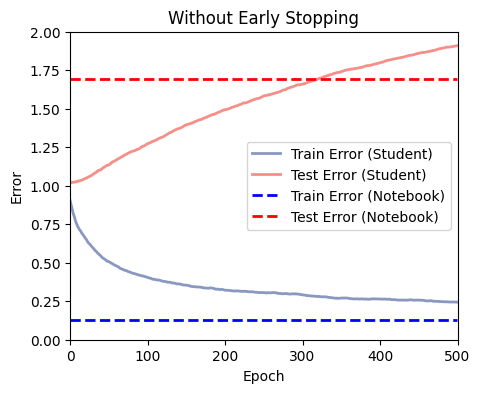

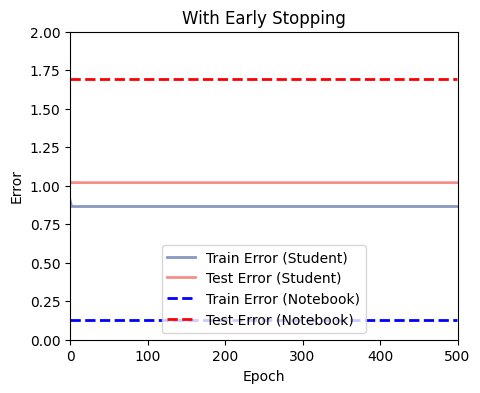

In [59]:
# Main code for Student-Teacher-Notebook framework

import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import SGD
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

################ パラメータ
r_n = 1  # number of repeats      [例：20]
nepoch = 500                    # [例：2000]
learnrate = 0.015               # [例：0.015]
N_x_t = 100  # 入力次元（教師） # [例：100]
N_y_t = 1  # 出力次元（教師）   # [例：1]
P = 100  # 例題数               # [例：100]
P_test = 1000  # テスト数       # [例：1000]

################ SNRに基づいて教師ネットワークの重み（variance_w）と出力ノイズ（variance_e）の分散の合計が 1 になるように設定
# Signal-to-Noise Ratio (SNR) を設定
SNR = float('0.05')             # [例：inf, 4, 0.05]
# SNRが無限大（ノイズが非常に小さい状態）の場合
if SNR == float('inf'):
    variance_w = 1  # 教師の重みの分散
    variance_e = 0  # 出力ノイズの分散はゼロ
else:
    # SNRが有限の場合の設定
    variance_w = SNR / (SNR + 1)  # 教師の重みの分散
    variance_e = 1 / (SNR + 1)    # 出力ノイズの分散

################# 生徒と教師は同じ次元数
N_x_s = N_x_t
N_y_s = N_y_t

################# ノートブックのパラメータ
# see Buhmann, Divko, and Schulten, 1989 for details regarding gamma and U terms
M = 500  # ノートブックのユニット数          [例：2000]
a = 0.05  # notebook sparseness              [例：0.05]
gamma = 0.6  # inhibition parameter          [例：0.6]
U = -0.15  # threshold for unit activation   [例：-0.15]
ncycle = 5  # 再帰サイクルの回数             [例：9]

#################  訓練エラー，テストエラー，再活性化エラーを格納するためのメトリック（ノートブックによって駆動される）
# Early stopping なし
train_error_all = np.zeros((r_n, nepoch)) # 訓練エラー（生徒）
test_error_all = np.zeros((r_n, nepoch)) # テストエラー（生徒）
N_train_error_all = np.zeros((r_n, nepoch)) # 訓練エラー（ノートブック）
N_test_error_all = np.zeros((r_n, nepoch)) # テストエラー（ノートブック）

# Early stopping あり
train_error_early_stop_all = np.zeros((r_n, nepoch))
test_error_early_stop_all = np.zeros((r_n, nepoch))



################ r_n 回シミュレーションを実行
for r in range(r_n):
    print(f'Run {r + 1}/{r_n}')
    torch.manual_seed(r)

    error_train_vector = np.zeros(nepoch)
    error_test_vector = np.zeros(nepoch)
    error_react_vector = np.zeros(nepoch)

    ######### 教師ネットワーク
    W_t = torch.normal(0, variance_w**0.5, size=(N_x_t, N_y_t)) # variance_w で教師の重みを設定
    noise_train = torch.normal(0, variance_e**0.5, size=(P, N_y_t)) # ラベルノイズの分散を設定

    # 訓練データ
    x_t_input = torch.normal(0, (1/N_x_t)**0.5, size=(P, N_x_t)) # 入力
    y_t_output = x_t_input @ W_t + noise_train # 出力
    # テストデータ
    noise_test = torch.normal(0, variance_e**0.5, size=(P_test, N_y_t))
    x_t_input_test = torch.normal(0, (1/N_x_t)**0.5, size=(P_test, N_x_t))
    y_t_output_test = x_t_input_test @ W_t + noise_test

    ######### ノートブックネットワーク
    # sparseness a で，P 個のランダムなバイナリインデックス（0または1）を生成
    N_patterns = torch.zeros(P, M, dtype=torch.bool) # M はノートブックのユニット数
    for n in range(P):
        N_patterns[n, torch.randperm(M)[:int(M*a)]] = 1  # torch.randperm(M) は 0 から M-1 までのランダムな整数を返す

    ##### ヘブ学習によるノートブックの再帰重み W_N の計算
    # (N_patterns_float - a) は各パターンから sparseness a を引いたもの
    # その転置行列と掛け算して，正規化定数で割る
    W_N = (N_patterns.float() - a).T @ (N_patterns.float() - a) / (M * a * (1 - a))
    W_N = W_N - gamma / (a * M)  # add global inhibiton term, see Buhmann, Divko, and Schulten, 1989
    W_N.fill_diagonal_(0) # 自己結合を削除（対角成分を 0 に設定）


    #####  ヘブ学習によるノートブックと生徒の重みの計算（双方向）
    ### ノートブックから生徒の重み（生徒の再活性化）
    W_N_S_Lin = (N_patterns.float() - a).T @ x_t_input / (M * a * (1 - a)) # 入力用．ノートブックパターンから sparseness a を引いたものと，訓練入力 x_t_input を掛け算
    W_N_S_Lout = (N_patterns.float() - a).T @ y_t_output / (M * a * (1 - a)) # 出力用．ノートブックパターンから sparseness a を引いたものと，訓練出力 y_t_output を掛け算

    ### 生徒からノートブックへの重み（部分的な手がかりを提供）
    W_S_N_Lin = x_t_input.T @ (N_patterns.float() - a) # 入力用．訓練入力 x_t_input と，ノートブックパターンから sparseness a を引いたものを掛け算
    W_S_N_Lout = y_t_output.T @ (N_patterns.float() - a) # 出力用．訓練出力 y_t_output と，ノートブックパターンから sparseness a を引いたものを掛け算

    ######### 生徒ネットワーク
    W_s = torch.normal(0, 0**0.5, size=(N_x_s, N_y_s)) # 生徒の重み W_s をゼロ初期化

    ######### オフライン訓練データの作成
    # ノートブックの再活性化から訓練データを作成
    # ノートブックパターンの再活性化結果を保存するための配列を初期化．速度を考慮してすべてのエポックで事前計算
    N_patterns_reactivated = torch.zeros(P, M, nepoch, dtype=torch.bool)

    print("Generating offline training data from notebook reactivations...")
    # ノートブックパターンの再活性化を生成
    for m in range(nepoch):
        if m % 10 == 0:
            print(f"Epoch {m}/{nepoch}")
        # Notebook pattern completion through recurrent dynamis
        # % Code below simulates hippocampal offline spontanenous
        # % reactivations by seeding the initial notebook state with a random
        # % binary pattern, then notebook goes through a two-step retrieval
        # % process: (1) Retrieving a pattern using dynamic threshold to
        # % ensure a pattern with sparseness a is retrieved (otherwise a silent
        # % attractor will dominate retrieval). (2) Using the
        # % retrieved pattern from (1) to seed a second round of pattern
        # % completion using a fixed-threshold method (along with a global
        # % inhibition term during encoding), so the retrieved patterns are
        # % not forced to have a fixed sparseness, in addition, there is a
        # % "silent  state" attractor when the seeding pattern lies far away
        # % from any of the encoded patterns.

        ####### 動的な閾値による，再帰サイクルの開始
        # 再活性化パターンを初期化
        Activity_dyn_t = torch.zeros(P, M, dtype=torch.float32)

        ##### 再帰活性化サイクルによる最初のパターンの生成
        # 初期の入力としてランダムパターンを使用
        for cycle in range(ncycle):
            if cycle <= 1:
                clamp = 1  # 最初の2サイクルではランダムパターンを強制する
            else:
                clamp = 0  # それ以降はランダムパターンの影響を減らす

            rand_patt = torch.rand(P, M) <= a # random seeding activity
            # ノートブックをランダムパターンでシーディング
            M_input = Activity_dyn_t + (rand_patt.float() * clamp)
            # ノートブックをオリジナルパターンでシーディング
            # M_input = Activity_dyn_t + (N_patterns.float() * clamp);

            # 現在の状態を計算
            M_current = M_input @ W_N
            # 出力を 0 から 1 の範囲にスケーリング
            scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
            M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)
            # スパース性に基づいた閾値を決定
            sorted_M_current = M_current.sort(dim=1, descending=True)[0]
            t_ind = torch.tensor(M * a).floor().int()
            t_ind[t_ind < 1] = 1
            t = sorted_M_current[torch.arange(P), t_ind - 1] # threshold for unit activations
            Activity_dyn_t = (M_current >= t.unsqueeze(1))

        Activity_dyn_t = Activity_dyn_t.float()


        ####### 固定した閾値による，パターンの作成の第二ラウンド
        Activity_fix_t = torch.zeros(P, M, dtype=torch.float32)
        for cycle in range(ncycle):
            if cycle <= 1:
                clamp = 1  # 最初の 2 サイクルでは動的な閾値の影響を強制する
            else:
                clamp = 0  # それ以降は動的な閾値の影響を減らす

            M_input = Activity_fix_t + Activity_dyn_t.float() * clamp
            # 現在の状態を計算
            M_current = M_input @ W_N
            # 固定閾値 U を用いてパターンを完成
            Activity_fix_t = M_current >= U  # U is the fixed threshold
        # 取得したパターンを保存
        N_patterns_reactivated[:, :, m] = Activity_fix_t.bool()

    # % Seeding notebook with original notebook patterns for calculating
    # % training error mediated by notebook (seeding notebook with student
    # % input via Student's input to Notebook weights, once pattern completion
    # % finishes, use the retrieved pattern to activate Student's output unit
    # % via Notebook to Student's output weights.

    print("Calculating training and test errors mediated by notebook...")

    # 初期化: ノートブックの活動を格納するテンソル
    Activity_notebook_train = torch.zeros(P, M, dtype=torch.float32)
    ##### ノートブックのパターン完成のための再活性化サイクル
    for cycle in range(ncycle):
        if cycle <= 1:
            clamp = 1
        else:
            clamp = 0

        # 生徒の入力からノートブックへの重みを使用してシードパターンを計算（x_t_input は訓練データの入力）
        seed_patt = x_t_input @ W_S_N_Lin
        # ノートブックへの入力としてシードパターンを追加
        M_input = Activity_notebook_train + seed_patt * clamp

        # ノートブックの活動を更新
        M_current = M_input @ W_N

        # 活動を 0 と 1 の間にスケーリング
        scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
        M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)

        # 活動のソートと閾値の計算
        sorted_M_current = M_current.sort(dim=1, descending=True)[0]
        t_ind = torch.tensor(M * a).floor().int()
        t_ind[t_ind < 1] = 1
        t = sorted_M_current[torch.arange(P), t_ind - 1]

        # 閾値に基づいて活動をバイナリに変換
        Activity_notebook_train = M_current >= t.unsqueeze(1)

    # ノートブックの活動を用いて学生の出力を計算
    N_S_output_train = Activity_notebook_train.float() @ W_N_S_Lout
    # ノートブックの訓練エラーを計算
    delta_N_train = y_t_output - N_S_output_train
    error_N_train = (delta_N_train ** 2).sum().item() / P

    # ノートブックの誤差はトレーニング中ずっと一定なので，各エポックに同じエラー値を入れる
    error_N_train_vector = np.ones(nepoch) * error_N_train
    N_train_error_all[r, :] = error_N_train_vector


    # ノートブックのテストデータの活動を初期化
    Activity_notebook_test = torch.zeros(P_test, M, dtype=torch.float32)
    ####### ノートブックのパターン完成のための再活性化サイクル
    for cycle in range(ncycle):
        if cycle <= 1:
            clamp = 1
        else:
            clamp = 0
        # テストデータからノートブックへの重みを使用してシードパターンを計算
        seed_patt = x_t_input_test @ W_S_N_Lin
        # ノートブックへの入力としてシードパターンを追加
        M_input = Activity_notebook_test + seed_patt * clamp

        # ノートブックの活動を更新
        M_current = M_input @ W_N

        # 活動を0と1の間にスケーリング
        scale = 1.0 / (M_current.max(dim=1)[0] - M_current.min(dim=1)[0])
        M_current = (M_current - M_current.min(dim=1)[0].unsqueeze(1)) * scale.unsqueeze(1)

        # 活動のソートと閾値の計算
        sorted_M_current = M_current.sort(dim=1, descending=True)[0]
        t_ind = torch.tensor(M * a).floor().int()
        t_ind[t_ind < 1] = 1
        t = sorted_M_current[torch.arange(P_test), t_ind - 1]

        # 閾値に基づいて活動をバイナリに変換
        Activity_notebook_test = M_current >= t.unsqueeze(1)

    # ノートブックの活動を用いてテスト出力を計算
    N_S_output_test = torch.matmul(Activity_notebook_test.float(), W_N_S_Lout)
    # ノートブックのテストエラーを計算
    delta_N_test = y_t_output_test - N_S_output_test
    error_N_test = (delta_N_test ** 2).sum().item() / P_test

    # エポックごとに同じエラー値を設定
    error_N_test_vector = np.ones(nepoch) * error_N_test
    N_test_error_all[r, :] = error_N_test_vector

    ######## 各エポックにおける，オフラインノートブック再活性化による生徒のトレーニング
    print("Starting Training...")
    for m in range(nepoch):
        if m % 10 == 0:
            print(f"Epoch {m}/{nepoch}")

        #### ノートブック再活性化に基づく生徒の入力と出力の計算
        N_S_input = N_patterns_reactivated[:, :, m].float() @ W_N_S_Lin
        N_S_output = N_patterns_reactivated[:, :, m].float() @ W_N_S_Lout

        ####  生徒ネットワークによる予測
        N_S_prediction = N_S_input @ W_s # ノートブック再活性化入力を用いた，生徒の予測出力
        S_prediction = x_t_input @ W_s # 実際の訓練入力を用いた，生徒の予測出力
        S_prediction_test = x_t_input_test @ W_s # 実際のテスト入力を用いた，生徒の予測出力

        ####  訓練エラーの計算
        delta_train = y_t_output - S_prediction
        error_train = (delta_train ** 2).sum().item() / P
        error_train_vector[m] = error_train

        ####  汎化誤差の計算
        delta_test = y_t_output_test - S_prediction_test
        error_test = (delta_test ** 2).sum().item() / P_test
        error_test_vector[m] = error_test

        #### 勾配降下法による重みの更新
        w_delta = N_S_input.T @ N_S_output - N_S_input.T @ N_S_input @ W_s
        W_s = W_s + learnrate * w_delta

    # 訓練誤差とテスト誤差の保存
    train_error_all[r, :] = error_train_vector
    test_error_all[r, :] = error_test_vector

    ###### Early stopping
    # 最小のテスト誤差とそのエポックを見つける
    min_v, min_p = torch.min(torch.tensor(error_test_vector), 0)

    # Early stopping による誤差の更新
    train_error_early_stop = error_train_vector.copy()
    train_error_early_stop[min_p + 1:] = error_train_vector[min_p]
    test_error_early_stop = error_test_vector.copy()
    test_error_early_stop[min_p + 1:] = error_test_vector[min_p]

    # Early stopping によるエラーを保存
    train_error_early_stop_all[r, :] = train_error_early_stop
    test_error_early_stop_all[r, :] = test_error_early_stop


###### Plotting
color_scheme = [(137 / 255, 152 / 255, 193 / 255), (245 / 255, 143 / 255, 136 / 255)]
line_w = 2
font_s = 12

# Early stopping なし
plt.figure(1)
plt.plot(range(nepoch), np.mean(train_error_all, axis=0), color=color_scheme[0], linewidth=line_w, label='Train Error (Student)')
plt.plot(range(nepoch), np.mean(test_error_all, axis=0), color=color_scheme[1], linewidth=line_w, label='Test Error (Student)')
plt.plot(range(nepoch), np.mean(N_train_error_all, axis=0), 'b--', linewidth=2, label='Train Error (Notebook)')
plt.plot(range(nepoch), np.mean(N_test_error_all, axis=0), 'r--', linewidth=2, label='Test Error (Notebook)')
plt.xlabel('Epoch', color='k')
plt.ylabel('Error', color='k')
plt.xlim([0, nepoch])
plt.ylim([0, 2])
plt.legend()
plt.title('Without Early Stopping', fontsize=font_s)
plt.gcf().set_size_inches(5, 4)
plt.show()

# Early stopping あり
plt.figure(2)
plt.plot(range(nepoch), np.mean(train_error_early_stop_all, axis=0), color=color_scheme[0], linewidth=line_w, label='Train Error (Student)')
plt.plot(range(nepoch), np.mean(test_error_early_stop_all, axis=0), color=color_scheme[1], linewidth=line_w, label='Test Error (Student)')
plt.plot(range(nepoch), np.mean(N_train_error_all, axis=0), 'b--', linewidth=line_w, label='Train Error (Notebook)')
plt.plot(range(nepoch), np.mean(N_test_error_all, axis=0), 'r--', linewidth=line_w, label='Test Error (Notebook)')
plt.xlabel('Epoch', color='k')
plt.ylabel('Error', color='k')
plt.xlim([0, nepoch])
plt.ylim([0, 2])
plt.legend()
plt.title('With Early Stopping', fontsize=font_s)
plt.gcf().set_size_inches(5, 4)
plt.show()